In [1]:
import qiskit as q

## QFT


In [2]:
pi = 3.1415926535
### VERSION DE QISKIT ####
### Ref: 
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [227]:
N = 3

qft = q.QuantumCircuit(N)

qft_rotations(qft,N)

# Invertimos el orden de los qubits para
# preservar la notación
for i in range(N//2):
    print(i,N-i-1)
    qft.swap(i,N-i-1)

0 2


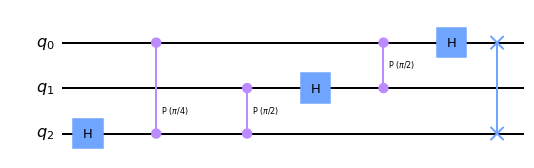

In [228]:
qft.draw("mpl")

[0, 1, 0, 0, 0, 0, 0, 0]
Statevector([ 3.53553391e-01-4.32978028e-17j,
              2.50000000e-01+2.50000000e-01j,
              1.58733857e-11+3.53553391e-01j,
             -2.50000000e-01+2.50000000e-01j,
             -3.53553391e-01+4.32978028e-17j,
             -2.50000000e-01-2.50000000e-01j,
             -1.58733857e-11-3.53553391e-01j,
              2.50000000e-01-2.50000000e-01j],
            dims=(2, 2, 2))


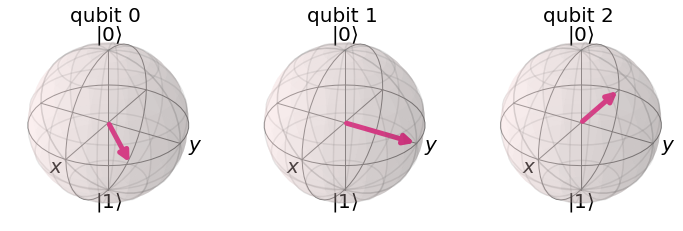

In [229]:
statesim = q.Aer.get_backend('statevector_simulator')
ini_vec = [0]*(2**N)

ini_vec[1] = 1
print(ini_vec)
ini_circ = q.QuantumCircuit(N)
ini_circ.initialize(ini_vec,range(N))
qft2 = ini_circ.compose(qft)
out = q.execute(qft2,statesim).result().get_statevector()

print(out)

q.visualization.plot_bloch_multivector(out)

In [230]:
def our_qft(Nq):
    qftc = q.QuantumCircuit(Nq)
    for i in range(Nq//2):
        qftc.swap(i,Nq-i-1)
    for control  in range(Nq):
        qftc.h(control)
        for target in reversed (range(control+1,Nq)):
            qftc.cp(pi/(2**(target-control)), target,control)
    return qftc.to_gate(label = "QFT")
    #return qftc

def inv_qft(Nq):
    g = our_qft(Nq).inverse()
    g.label = "QFT$^\dagger$"
    return g
#our_qft(N).draw("mpl")

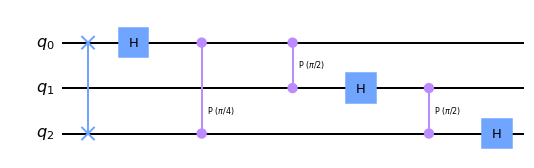

In [231]:
qfttest = q.QuantumCircuit(N)
qfttest.append(our_qft(N),range(N))
qfttest.decompose().draw("mpl")

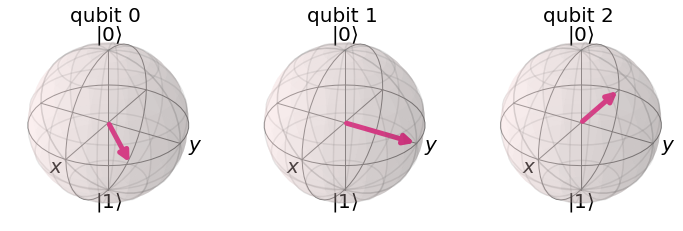

In [232]:
# Probamos esta otra implementación
ini_vec = [0]*(2**N)
ini_vec[1] = 1
ini_circ = q.QuantumCircuit(N)
ini_circ.initialize(ini_vec,range(N))
ini_circ.append(our_qft(N),range(N))
#ini_circ.append(inv_qft(N),range(N))
out = q.execute(ini_circ,statesim).result().get_statevector()

#print(out)

q.visualization.plot_bloch_multivector(out)

## Quantum Phase Estimation

In [233]:
def CU_power(k,phi):
    U = q.circuit.library.RZGate(2*k*phi).control(1)
    U.label = "$U^{" +str(k)+"}$"
    return U
    

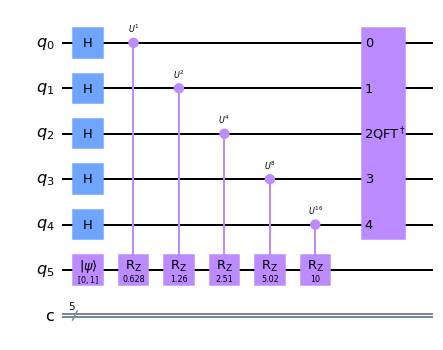

In [234]:
N = 5
#phi = pi/4
phi = 0.314
qpe = q.QuantumCircuit(N+1,N)
qpe.initialize([0,1],N)
qpe.h(range(N))
for i in range(N):
    qpe.append(CU_power(2**(i),phi),[i,N])
qpe.append(inv_qft(N),range(N))
qpe.draw("mpl")

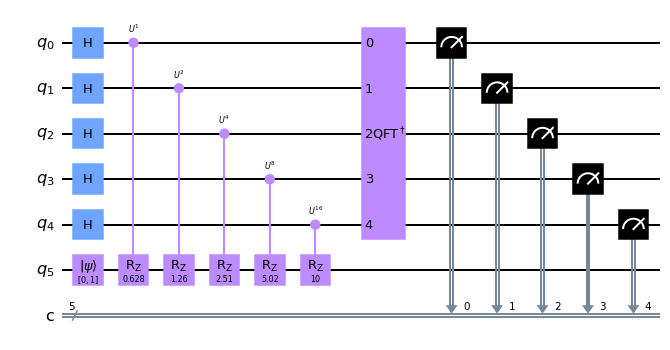

In [235]:
qpe.measure(range(N), range(N))
qpe.draw("mpl")

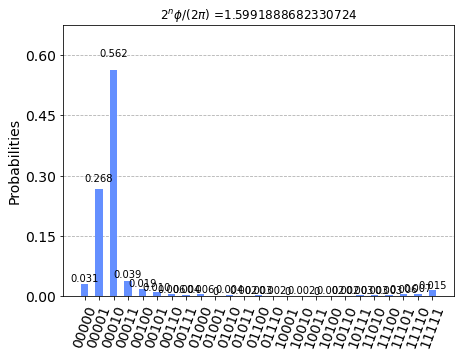

In [236]:
simulator = q.Aer.get_backend('aer_simulator')
trans = q.transpile(qpe,simulator)
result = simulator.run(trans).result()
counts = result.get_counts(trans)
q.visualization.plot_histogram(counts, title='$2^n \phi /(2\pi)$ =' +str(phi*2**N/(2*pi)))